In [1]:
from matplotlib import pyplot as plt
import numpy as np
from netCDF4 import Dataset
import netCDF4
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
import pandas as pd
import pickle
import gsw
import cftime
import datetime
from scipy import ndimage
from mpl_toolkits import mplot3d
from matplotlib import cm





SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [2]:
#constant
path='/storage/jlavoie/Research/Data/Budget/'
fTEMP=Dataset(path+'b.e11.BRCP85C5CNBDRD.f09_g16.002.pop.h.TEMP.200601-208012.nc')
fTEMP1=Dataset(path+'b.e11.B20TRC5CNBDRD.f09_g16.002.pop.h.TEMP.192001-200512.nc')
faice=Dataset(path+'b.e11.BRCP85C5CNBDRD.f09_g16.002.cice.h.aice_nh.200601-208012.nc')

months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
nbDaysInMonth=[31,28,31,30,31,30,31,31,30,31,30,31]

rho_sw=fTEMP['rho_sw'][:]*1000#kg m-3
cp_sw=fTEMP['cp_sw'][:]*0.0001#J kg-1 K-1
T2E=rho_sw*cp_sw#J degC-1 m-3

latent_heat_vapor=fTEMP['latent_heat_vapor'][:]
latent_heat_fusion=fTEMP1['latent_heat_fusion'][:]*1e-7*1000# erg/g -> J/kg
rho_ice=917#kg/m3

dz=fTEMP['dz'][:]*0.01# m
dzw=fTEMP['dzw'][:]*0.01# m
Tf=-1.8
tlong=fTEMP['TLONG'][:]
tlat=fTEMP['TLAT'][:]
tlon=faice['TLON'][:]
tla=faice['TLAT'][:]
z_t=fTEMP['z_t'][:]*0.01#m
z_w=fTEMP['z_w'][:]*0.01#m
z_w_top=fTEMP['z_w_top'][:]*0.01#m
z_w_bot=fTEMP['z_w_bot'][:]*0.01#m


timeDay1=fTEMP1['time']
Jan1920=cftime.DatetimeNoLeap(1920, 1, 1, 0, 0, 0, 0, 0, 0)
time1 = netCDF4.num2date(timeDay1[:],timeDay1.units,calendar=timeDay1.calendar)
time1=[Jan1920]+list(time1[:-1])
time_boundDay1=fTEMP1['time_bound']
time_bound1 = netCDF4.num2date(time_boundDay1[:],timeDay1.units,calendar=timeDay1.calendar)
ind1970, ind1980= 600,720

timeDay=fTEMP['time']
time = netCDF4.num2date(timeDay[:],timeDay.units,calendar=timeDay.calendar)
#fix month error in cesm
Jan2006=cftime.DatetimeNoLeap(2006, 1, 1, 0, 0, 0, 0, 0, 0)
time=[Jan2006]+list(time[:-1])
time_boundDay=fTEMP['time_bound']
time_bound = netCDF4.num2date(time_boundDay[:],timeDay.units,calendar=timeDay.calendar)
ind2010=12*4
ind2020=12*14




# create mask CB
maskCBocn=np.zeros((384,320))
for i in range(384):
    for j in range(320):
        if  205<=tlong[i,j]<=230 and 72<=tlat[i,j]<=80:
            maskCBocn[i,j]=1
            
maskCBice=np.zeros((104,320))
for i in range(104):
    for j in range(320):
        if  205<=tlon[i,j]<=230 and 72<=tla[i,j]<=80:
            maskCBice[i,j]=1


pathSaved='/storage/jlavoie/Research/Data/saved/'
with open(pathSaved+"ajProfiles.txt", "rb") as fp:  
    ajProfiles=pickle.load(fp)
print('ajloaded!')
with open(pathSaved+"itpProfiles.txt", "rb") as fp:  
    itpProfiles=pickle.load(fp)
print('itploaded!')
z_O=ajProfiles[0]['D']


ajloaded!
itploaded!


# domain

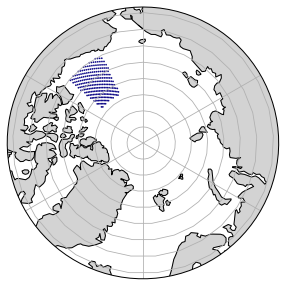

In [3]:
fig = plt.figure(figsize=[5,5])
ax = plt.subplot( projection=ccrs.NorthPolarStereo())
ax.set_extent([-180, 180,65, 90], ccrs.PlateCarree())
ax.gridlines()
ax.add_feature(cartopy.feature.COASTLINE)
ax.set_boundary(circle, transform=ax.transAxes)
scat=ax.scatter(tlong[maskCBocn==1],tlat[maskCBocn==1],c=np.ones(249),s=0.5,transform= ccrs.PlateCarree(),cmap='plasma')
ax.add_feature(cartopy.feature.LAND,color='lightgray')

# T vs SIC

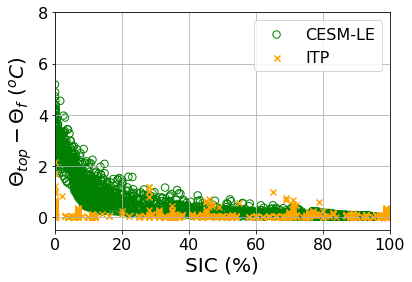

In [4]:
# t surface vs sic for september
m=8
aiceCB=np.array([faice['aice'][ind2010+m:ind2020+m:12][:,maskCBice==1] for m in range(12)])
TEMPCB=np.array([fTEMP['TEMP'][ind2010+m:ind2020+m:12][:,:,maskCBocn==1] for m in range(12)])
plt.scatter(aiceCB[m].ravel(),TEMPCB[m,:,0].ravel()--1.8,marker='o', s=55,edgecolors='green',label='CESM-LE',facecolors='none')
plt.xlabel('SIC (%)')
plt.ylabel('$\Theta_{top} -\Theta_f$ ($^oC$)')
plt.grid()
plt.xlim(0,100)
plt.ylim(-0.5,8)
label=True
for pro in itpProfiles:
    if pro['month']==9:
        plt.scatter(pro['sic']*100,(pro['T']-gsw.pt_from_CT(pro['S'],gsw.CT_freezing(pro['S'],z_O,1)))[10],marker='x',color='orange',label='ITP' if label else None)
        label=False
plt.legend()


# 3D individual instruments

/aos/home/jlavoie/.conda/envs/a/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


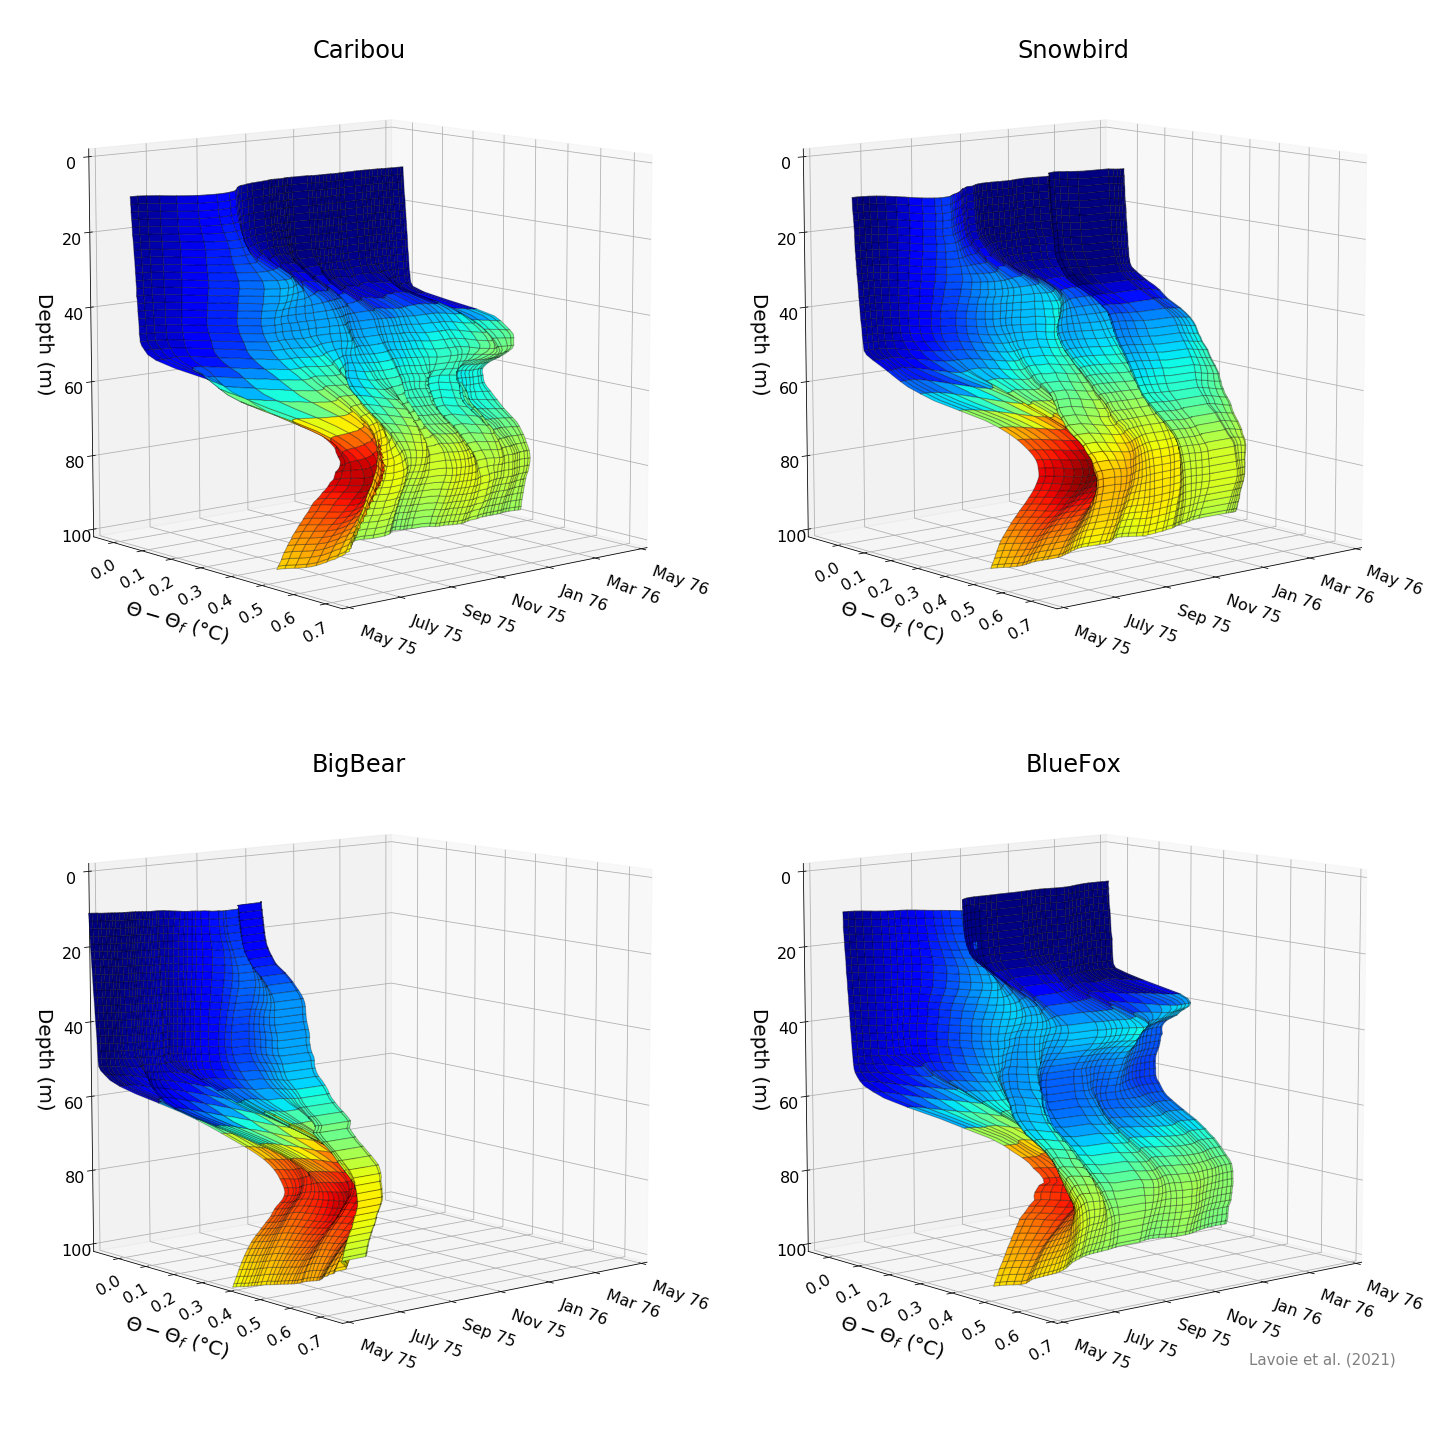

In [5]:
#4 camps with z axis depth
camps=['Caribou','Snowbird','BigBear','BlueFox']

#define xticks
xtickdt=[datetime.date(1975,5,1),datetime.date(1975,7,1),datetime.date(1975,9,1),datetime.date(1975,11,1),
              datetime.date(1976,1,1),datetime.date(1976,3,1),datetime.date(1976,5,1)]
xtickPos=[pd.Timestamp(x).to_julian_date() for x in xtickdt]
xtickLab=['May 75','July 75','Sep 75','Nov 75','Jan 76','Mar 76', 'May 76']
fig = plt.figure(figsize=(20,20))
for nCamp in range(4):
    # get date, and delta T for snowbird
    datesSB=np.array([pro['datetime'] for pro in ajProfiles if pro['camp']==camps[nCamp] ])
    dTSB=np.array([pro['PT']-gsw.pt_from_CT(pro['S'],gsw.CT_freezing(pro['S'],z_O,1)) for pro in ajProfiles if pro['camp']==camps[nCamp]])
    # sort
    arr1inds = datesSB.argsort()
    datesSBs = datesSB[arr1inds]
    dTSBs = dTSB[arr1inds]
    #smooth
    smoothdTSBs=ndimage.gaussian_filter1d(dTSBs, 10, 0)
    
    # 3d vertical is temperature
    # put date in julian to be able to plot
    juliandatesSB=[pd.Timestamp(x).to_julian_date() for x in datesSBs]
    depth,time=np.meshgrid(z_O[:100],juliandatesSB)
    ax = fig.add_subplot(2, 2, nCamp+1, projection='3d')
    col=cm.jet(smoothdTSBs[:,:100]/0.73)#0.73 is overall max
    cont=ax.plot_surface( time, smoothdTSBs[:,:100],depth,facecolors=col, cmap='jet', edgecolor='k',linewidth=1)
    cont.set_edgecolor('#00000050')
    #ax.plot_wireframe( time, smoothdTSBs[:,:100],depth, color='black', alpha=0.5, linewidth=1, rstride=10, cstride=10)
    ax.set_zlabel('Depth (m)',labelpad=10)
    ax.set_ylabel(r'${\Theta -\Theta_f}$ (°C)',labelpad=20)
    ax.set_zlim(100,0)
    #plt.colorbar(cont)
    ax.invert_xaxis()# make date start in corner closest to use
    ax.view_init(10,50)# camera view#10,50
    # x tick with real date not julian
    plt.xticks(xtickPos,xtickLab,rotation=-20,ha='left');

    plt.yticks(rotation=30)
    ax.set_title(camps[nCamp])
fig.text(0.87,0.05,'Lavoie et al. (2021)',color='grey',fontsize=15)
plt.tight_layout()

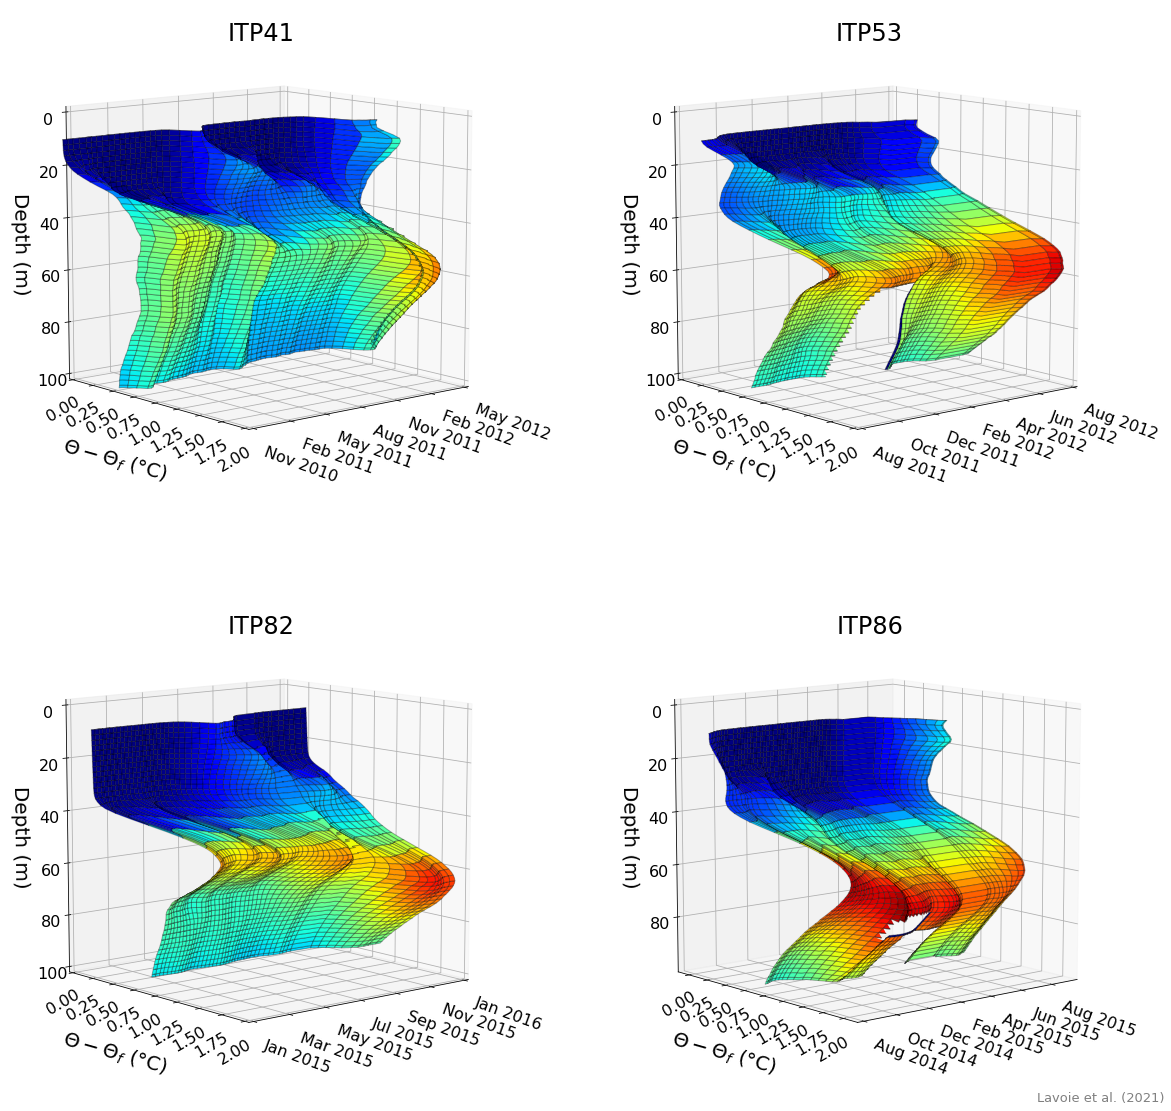

In [6]:
# individual itps
#4 itp with z axis depth

fig = plt.figure(figsize=(20,20))
count=1
for n in ['41','53','82','86']:
#for n in itpN:
    # get date, and delta T for snowbird
    datesITP=np.array([pro['datetime'] for pro in itpProfiles if pro['itp']==n ])
    dTITP=np.array([pro['PT']-gsw.pt_from_CT(pro['S'],gsw.CT_freezing(pro['S'],z_O,1)) for pro in itpProfiles if pro['itp']==n])
    # sort
    arr1inds = datesITP.argsort()
    datesITPs = datesITP[arr1inds]
    dTITPs = dTITP[arr1inds]
    #smooth
    smoothdTITPs=ndimage.gaussian_filter1d(dTITPs, 20, 0)
    
    # 3d vertical is temperature
    # put date in julian to be able to plot
    juliandatesITP=[pd.Timestamp(x).to_julian_date() for x in datesITPs]
    depth,time=np.meshgrid(z_O[:100],juliandatesITP)
    ax = fig.add_subplot(2,2, count, projection='3d')
    count+=1
    col=cm.jet(smoothdTITPs[:,:100]/2)#2 is overall max
    cont=ax.plot_surface( time, smoothdTITPs[:,:100],depth,facecolors=col, cmap='jet')
    cont.set_edgecolor('#00000050')
    #ax.plot_wireframe( time, smoothdTITPs[:,:100],depth, color='black', alpha=0.5, linewidth=1)
    ax.set_zlabel('Depth (m)',labelpad=10)
    ax.set_ylabel(r'${\Theta -\Theta_f}$ (°C)',labelpad=25)
    ax.set_zlim(100,0)
    ax.set_ylim(0,2)
    #plt.colorbar(cont)
    ax.invert_xaxis()# make date start in corner closest to use
    ax.view_init(10,50)# camera view
    # x tick with real date not julian
    #plt.xticks(juliandatesITP[::70],
               #[str(x.day)+ ' '+ months[x.month -1] +' '+str(x.year) for x in datesITPs[::70]],rotation=-20,ha='left');
    
    if n=='41':
        xtickdt=[datetime.date(2010,11,1),datetime.date(2011,2,1),datetime.date(2011,5,1),datetime.date(2011,8,1),
                  datetime.date(2011,11,1),datetime.date(2012,2,1),datetime.date(2012,5,1)]
    elif n=='53':
        xtickdt=[datetime.date(2011,8,1),datetime.date(2011,10,1),datetime.date(2011,12,1),datetime.date(2012,2,1),
                  datetime.date(2012,4,1),datetime.date(2012,6,1),datetime.date(2012,8,1)]
    elif n=='82':
        xtickdt=[datetime.date(2015,1,1),datetime.date(2015,3,1),datetime.date(2015,5,1),datetime.date(2015,7,1),
                  datetime.date(2015,9,1),datetime.date(2015,11,1),datetime.date(2016,1,1)]
    elif n=='86':
        xtickdt=[datetime.date(2014,8,1),datetime.date(2014,10,1),datetime.date(2014,12,1),datetime.date(2015,2,1),
                  datetime.date(2015,4,1),datetime.date(2015,6,1),datetime.date(2015,8,1)]
    xtickPos=[pd.Timestamp(x).to_julian_date() for x in xtickdt]
    xtickLab=[months[x.month -1] +' '+str(x.year) for x in xtickdt]
    plt.xticks(xtickPos,xtickLab,rotation=-20,ha='left');
    plt.yticks(rotation=30)
    ax.set_title('ITP'+n)
#plt.tight_layout()
fig.text(0.84,0.12,'Lavoie et al. (2021)',color='grey',fontsize=13)
plt.autoscale()

# Extra melt from PW

In [7]:
heat=0.66# Wm-3
dz=10 #m
latent_heat_fusion=fTEMP1['latent_heat_fusion'][:]*1e-7*1000# erg/g -> J/kg
rho_ice=917#kg/m3
year=3
y2s=365*24*3600
heat*dz*year*y2s/(latent_heat_fusion*rho_ice)

2.0405453673805054